In [1]:
# All project packages imported at the start

# Project packages
import pandas as pd
import numpy as np

# Visualisations
import matplotlib.pyplot as plt 
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import norm, skew
from statistics import mode

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, Ridge, RidgeCV, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# Reading in the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print("\nThe train data size is: {} ".format(train.shape)) 
print("The test data size is: {} ".format(test.shape))


The train data size is: (1460, 81) 
The test data size is: (1459, 80) 


In [4]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' colum since it's unnecessary for the prediction process
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

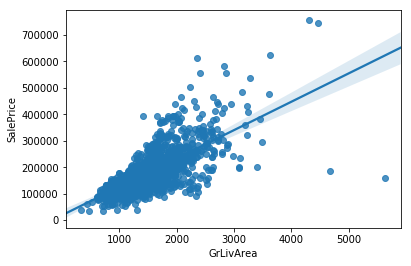

In [5]:
# Data Processing

# Checking for outliers in GrLivArea as indicated in dataset documentation
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=True)
plt.show()

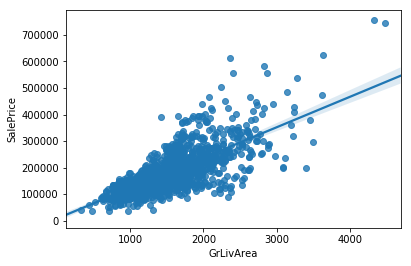

In [6]:
# Removing two very extreme outliers in the bottom right hand corner
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Re-check graph
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=True)
plt.show()

Text(0.5,1,'SalePrice distribution')

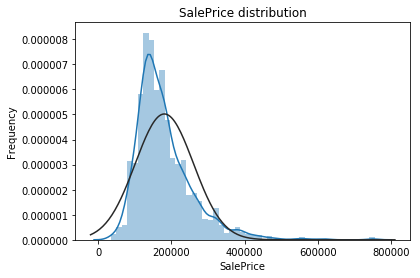

In [7]:
(mu, sigma) = norm.fit(train['SalePrice'])

# 1. Plot Sale Price
sns.distplot(train['SalePrice'] , fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


In [8]:
# Applying a log(1+x) transformation to SalePrice
train["SalePrice"] = np.log1p(train["SalePrice"])

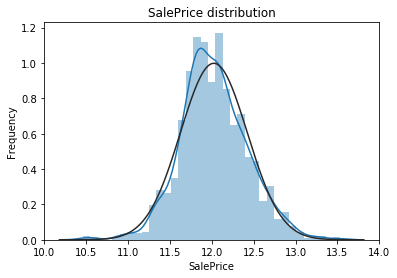

In [9]:
# 1. Plot Sale Price
sns.distplot(train['SalePrice'] , fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

In [10]:
# Saving train & test shapes
ntrain = train.shape[0]
ntest = test.shape[0]

# Creating y_train variable
y_train = train.SalePrice.values

# New all encompassing dataset
all_data = pd.concat((train, test)).reset_index(drop=True)

# Dropping the target
all_data.drop(['SalePrice'], axis=1, inplace=True)

# Printing all_data shape
print("all_data size is: {}".format(all_data.shape))

all_data size is: (2917, 79)


In [11]:
# Getting a missing % count
all_data_missing = (all_data.isnull().sum() / len(all_data)) * 100
all_data_missing = all_data_missing.drop(all_data_missing[all_data_missing == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Percentage':all_data_missing})
missing_data.head(30)

,Missing Percentage
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5,1,'Percent missing data by feature')

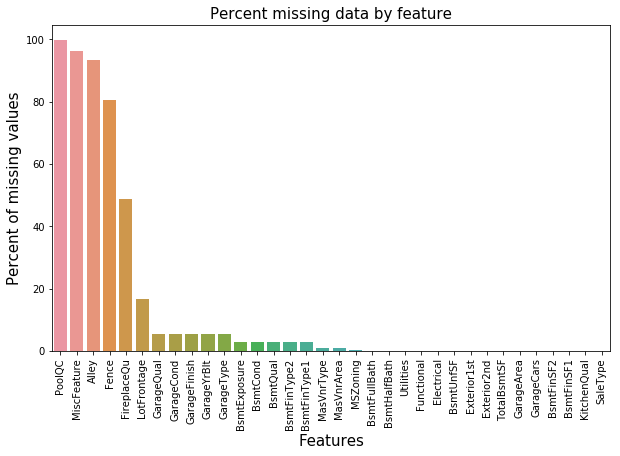

In [12]:
# Visualising missing data
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Missing Percentage'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

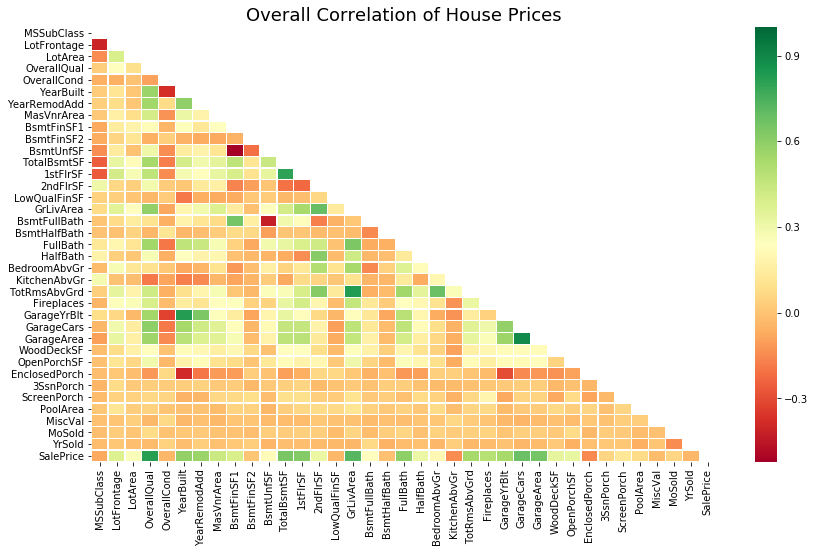

In [13]:
# Initiate correlation matrix
corr = train.corr()
# Set-up mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set-up figure
plt.figure(figsize=(14, 8))
# Title
plt.title('Overall Correlation of House Prices', fontsize=18)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

In [14]:
# All columns where missing values can be replaced with 'None'
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

In [15]:
# All columns where missing values can be replaced with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

In [16]:
# All columns where missing values can be replaced with the mode (most frequently occurring value)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [17]:
# Imputing LotFrontage with the median (middle) value
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [18]:
# Checking the new missing % count
all_data_missing = (all_data.isnull().sum() / len(all_data)) * 100
all_data_missing = all_data_missing.drop(all_data_missing[all_data_missing == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':all_data_missing})
missing_data.head(30)

,Missing Ratio


In [19]:
# Converting those variables which should be categorical, rather than numeric
for col in ('MSSubClass', 'OverallCond', 'YrSold', 'MoSold'):
    all_data[col] = all_data[col].astype(str)

In [20]:
# Applying a log(1+x) transformation to all skewed numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Compute skewness
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

# Fix for skewness
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [21]:
# Creating a new feature: Total Square Footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [22]:
# Identifying features where a class is over 97% represented
low_var_cat = [col for col in all_data.select_dtypes(exclude=['number']) if 1 - sum(all_data[col] == mode(all_data[col]))/len(all_data) < 0.03]
low_var_cat

['Condition2', 'Heating', 'PoolQC', 'RoofMatl', 'Street', 'Utilities']

In [23]:
# Dropping these columns from both datasets
all_data = all_data.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'PoolQC'], axis=1)

In [24]:
# List of columns to Label Encode
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Check on data shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 74)


In [25]:
# Get dummies
all_data = pd.get_dummies(all_data)

all_data.shape

(2917, 197)

In [26]:
# Now to return to separate train/test sets for Machine Learning
train = all_data[:ntrain]
test = all_data[ntrain:]

In [27]:
# Set up variables
X_train = train
X_test = test

# Defining two rmse_cv functions
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

Text(0,0.5,'Rmse')

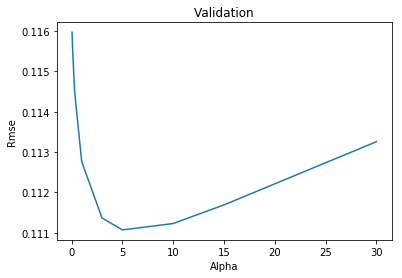

In [28]:
# Setting up list of alpha's
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30]

# Iterate over alpha's
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
# Plot findings
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [29]:
# 5 looks like the optimal alpha level, so let's fit the Ridge model with this value
model_ridge = Ridge(alpha = 5)

Text(0,0.5,'Rmse')

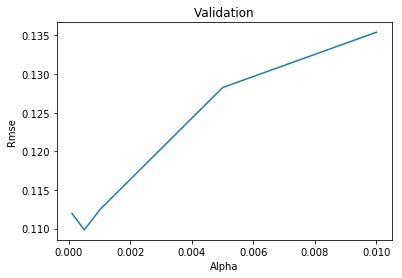

In [30]:
# Setting up list of alpha's
alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

# Iterate over alpha's
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [31]:
# Initiating Lasso model
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005))

Text(0,0.5,'Rmse')

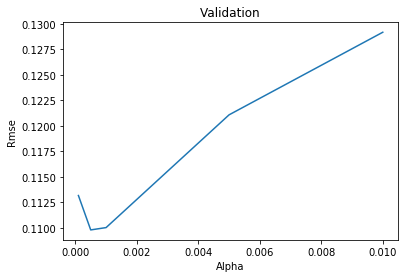

In [32]:
# Setting up list of alpha's
alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

# Iterate over alpha's
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_elastic = pd.Series(cv_elastic, index = alphas)
cv_elastic.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [33]:
# Initiating ElasticNet model
model_elastic = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005))

Text(0,0.5,'Rmse')

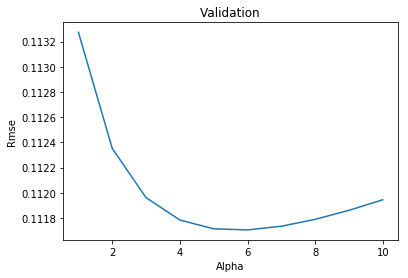

In [34]:
# Setting up list of alpha's
alphas = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# Iterate over alpha's
cv_krr = [rmse_cv(KernelRidge(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_krr = pd.Series(cv_krr, index = alphas)
cv_krr.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [35]:
# Initiatiing KernelRidge model
model_krr = make_pipeline(RobustScaler(), KernelRidge(alpha=6, kernel='polynomial', degree=2.65, coef0=6.9))

In [36]:
# Initiating Gradient Boosting Regressor
model_gbr = GradientBoostingRegressor(n_estimators=1200, 
                                      learning_rate=0.05,
                                      max_depth=4, 
                                      max_features='sqrt',
                                      min_samples_leaf=15, 
                                      min_samples_split=10, 
                                      loss='huber',
                                      random_state=5)

In [37]:
# Fitting all models with rmse_cv function, apart from CatBoost (still yet to crack this so performaing a simple fit for now)
cv_ridge = rmse_cv(model_ridge).mean()
cv_lasso = rmse_cv(model_lasso).mean()
cv_elastic = rmse_cv(model_elastic).mean()
cv_krr = rmse_cv(model_krr).mean()
cv_gbr = rmse_cv(model_gbr).mean()

In [38]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Ridge',
              'Lasso',
              'ElasticNet',
              'Kernel Ridge',
              'Gradient Boosting Regressor',
              ],
    'Score': [cv_ridge,
              cv_lasso,
              cv_elastic,
              cv_krr,
              cv_gbr]})

# Build dataframe of values
result_df = results.sort_values(by='Score', ascending=True).reset_index()
result_df.head(8)

,index,Model,Score
0,1,Lasso,0.109437
1,2,ElasticNet,0.109629
2,3,Kernel Ridge,0.111035
3,0,Ridge,0.111070
4,4,Gradient Boosting Regressor,0.112703


Text(0.5,1,'RMSE')

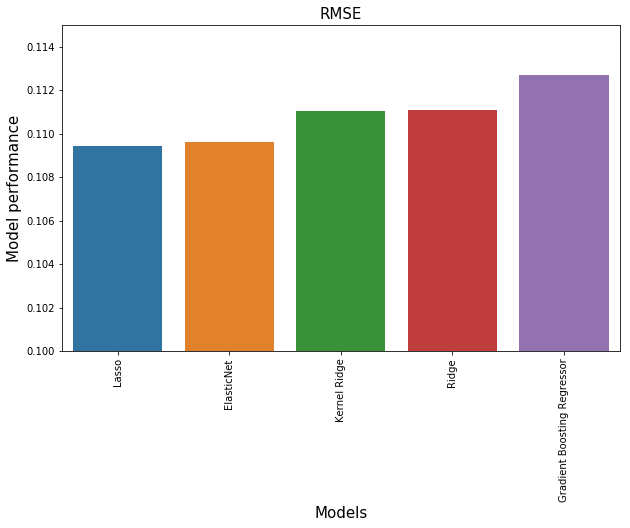

In [39]:
# Plotting model performance
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model performance', fontsize=15)
plt.ylim(0.10, 0.115)
plt.title('RMSE', fontsize=15)

In [40]:
# Fit and predict all models
model_lasso.fit(X_train, y_train)
lasso_pred = np.expm1(model_lasso.predict(X_test))

model_elastic.fit(X_train, y_train)
elastic_pred = np.expm1(model_elastic.predict(X_test))

model_ridge.fit(X_train, y_train)
ridge_pred = np.expm1(model_ridge.predict(X_test))


model_gbr.fit(X_train, y_train)
gbr_pred = np.expm1(model_gbr.predict(X_test))


model_krr.fit(X_train, y_train)
krr_pred = np.expm1(model_krr.predict(X_test))


In [41]:
# Create stacked model
stacked = (lasso_pred + elastic_pred + ridge_pred + krr_pred + gbr_pred) / 5
# Setting up competition submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = stacked
sub.to_csv('house_price_predictions.csv',index=False)